# Introduction to Binary Text Classification


**Text classification** is the processs of training a model to recognize key features from text, and then classify or assign a label to that text. In this project, we will be using a **binary classifier** to decide if an IMDB review is negative or positive. 

**Text classification** can also be set up for **multi-class classification**, where you want to classify text into more than two categories, but for the purposes of thiss introduction, we will stay with binary classification.

We will begin with importing our dependencies:

In [1]:
import matplotlib.pyplot as plt
import os
import re
import shutil
import string
import tensorflow as tf

from tensorflow.keras import layers
from tensorflow.keras import losses


## Sentiment Analysis

The IMDB database contains 50,000 entries, which are evening split between positive and negative reviews. This creates a balances dataset, the benefits of this is that a model with unbalanced data is that the model will generally lean towards the more common sentiment. 

For example, if our training dataset contained 90% negative reviews, the model would expect to a high percentage of reviews being negative in testing or deployment. This would result in the model incorrectly identifying many positive reviews as negative, thusly decreasing model accuracy. 

Unlike most datasets, the IMDB dataset has already been split into a 50/50 split. This means that there are 25,000 in the training dataset and 25,000 in the testing dataset. Furthermore, each dataset is split 50/50 positive to negative reviews, meaning there are 12,500 positive and 12,500 negative reviews in each segment of the database.

While this 50/50 split of training and testing data could be a problem, however, since we have a balanced dataset, we can mitigate many problems with training from that alone.


### Download and explore the IMDB dataset

We will download the data from the stanford.edu website, and then explore the file structure. Unlike many introductory projects, this model will use a more complex ETL process.

In [2]:
url = "https://ai.stanford.edu/~amaas/data/sentiment/aclImdb_v1.tar.gz"

dataset = tf.keras.utils.get_file("aclImdb_v1", url,
                                    untar=True, cache_dir='.',
                                    cache_subdir='')

dataset_dir = os.path.join(os.path.dirname(dataset), 'aclImdb')

84125825/84125825 [==============================] - 9s 0us/step


The following code will show us the files and folders in a given path.

We can see several files, "imdbEr.txt", and folders, "train", "test", etc. 

In [3]:
os.listdir(dataset_dir)

['imdbEr.txt', 'README', 'test', 'imdb.vocab', 'train']

We will create a training directory called "train", and then take a look at this new directory to see if we can find the key folders or files we need.

In [4]:
train_dir = os.path.join(dataset_dir, 'train')
os.listdir(train_dir)

['urls_neg.txt',
 'labeledBow.feat',
 'neg',
 'urls_pos.txt',
 'unsupBow.feat',
 'unsup',
 'pos',
 'urls_unsup.txt']

The `pos` and `neg` directories contain the text files, each of which is a single movie review.

<br>

We can take a look at any of these reviews, which is alwayss a great idea because it helpss us get more familiar with the data as well as perform some QA on the dataset.

In [5]:
sample_file = os.path.join(train_dir, 'pos/1181_9.txt')
with open(sample_file) as f:
  print(f.read())

Rachel Griffiths writes and directs this award winning short film. A heartwarming story about coping with grief and cherishing the memory of those we've loved and lost. Although, only 15 minutes long, Griffiths manages to capture so much emotion and truth onto film in the short space of time. Bud Tingwell gives a touching performance as Will, a widower struggling to cope with his wife's death. Will is confronted by the harsh reality of loneliness and helplessness as he proceeds to take care of Ruth's pet cow, Tulip. The film displays the grief and responsibility one feels for those they have loved and lost. Good cinematography, great direction, and superbly acted. It will bring tears to all those who have lost a loved one, and survived.


### Load the dataset

We will now load the data off disk and prepare it into a format suitable for training. 

<br>

To do so, you will use the helpful ***text_dataset_from_directory*** utility, which expects a directory structure as follows:

```
main_directory/
...class_a/
......a_text_1.txt
......a_text_2.txt
...class_b/
......b_text_1.txt
......b_text_2.txt
```

So what does this all mean? 

Essentially, we need to create a file system that splits our two classes (binary) into `class_a` and `class_b`, which in our case is positive and negative reviews.

<br>

Since our data has folders we do not need for processing, we will remove these with the follow command.

In [6]:
remove_dir = os.path.join(train_dir, 'unsup')
shutil.rmtree(remove_dir)

We will now use the `text_dataset_from_directory` utility to create a labeled `tf.data.Dataset`. 


<br>

It is a best practice to divide our data into three segments: **train**, **validation**, and **test**. 

Since this dataset has already been segmented into train and test, we can create a validation dataset from the testing data. We will do an 80/20 split of the data, but you can change this as required.

<br>

Using the validation_split line of code below will split this data for us. Keep in mind, you will pass through the argument for the validation percentage, so in this case we will use `0.2` or 20%, but you could use `0.3` for a 70/30 split for example.

In [7]:
batch_size = 32
seed = 42

raw_train_ds = tf.keras.utils.text_dataset_from_directory(
    'aclImdb/train', 
    batch_size=batch_size, 
    validation_split=0.2, 
    subset='training', 
    seed=seed)

Found 25000 files belonging to 2 classes.
Using 20000 files for training.


We can see that the previous command found 25,000 entries, and will use 20,0000 entries for training, or 80% of 25,000.


Now we can train a model by passing a dataset directly to `model.fit`, but we can also iterate over the dataset and print out a few examples as follows, which once again is always a great idea for assuring your commands are correct and you are getting the results as expected.

In [8]:
for text_batch, label_batch in raw_train_ds.take(1):
  for i in range(3):
    print("Review", text_batch.numpy()[i])
    print("Label", label_batch.numpy()[i])

Review b'"Pandemonium" is a horror movie spoof that comes off more stupid than funny. Believe me when I tell you, I love comedies. Especially comedy spoofs. "Airplane", "The Naked Gun" trilogy, "Blazing Saddles", "High Anxiety", and "Spaceballs" are some of my favorite comedies that spoof a particular genre. "Pandemonium" is not up there with those films. Most of the scenes in this movie had me sitting there in stunned silence because the movie wasn\'t all that funny. There are a few laughs in the film, but when you watch a comedy, you expect to laugh a lot more than a few times and that\'s all this film has going for it. Geez, "Scream" had more laughs than this film and that was more of a horror film. How bizarre is that?<br /><br />*1/2 (out of four)'
Label 0
Review b"David Mamet is a very interesting and a very un-equal director. His first movie 'House of Games' was the one I liked best, and it set a series of films with characters whose perspective of life changes as they get into 

We can see that the reviews contain "normal" or raw text, such as letters, punctuation, etc. as well as some HTML tags, such as `<br/>`. If you are new to NLP, you will know that these are red flags for your data, and we will need to address this before we can train a model.

After the "Review" we can also see a "Label", which are either 0 or 1 (binary). We can see clearly from the reviews above that a "0" is a negative review, and a "1" is a positive review. 

With this said, it may not always be this easy, and we should trust the data source when we know it is curated a such, so we will check the `class_names` property in our dataset as follows:


In [9]:
print("Label 0 corresponds to", raw_train_ds.class_names[0])
print("Label 1 corresponds to", raw_train_ds.class_names[1])

Label 0 corresponds to neg
Label 1 corresponds to pos


We will now use the remaining 5,000 reviews from the training set for validation.

<br>

We will `raw_val_ds` and `raw_test_ds` for the new validation and test datasets, respsectfully.

In [10]:
raw_val_ds = tf.keras.utils.text_dataset_from_directory(
    'aclImdb/train', 
    batch_size=batch_size, 
    validation_split=0.2, 
    subset='validation', 
    seed=seed)

Found 25000 files belonging to 2 classes.
Using 5000 files for validation.


In [11]:
raw_test_ds = tf.keras.utils.text_dataset_from_directory(
    'aclImdb/test', 
    batch_size=batch_size)

Found 25000 files belonging to 2 classes.


## Prepare the dataset for training

We wll now standardize, tokenize, and vectorize the data. Since we are using TenssorFlow, we can use the `tf.keras.layers.TextVectorization` layer directly in the model.

So what does this mean?

These are all data preprocessing steps that are required to pass the data through an NLP model successfully.

- **Standardization**: The removal of punctuation and HTML tags, a well as converting all text to lowercase.

- **Tokenization**: Is the act of splitting up the text into "tokens" or segments. This can be done by breaking up a paragraph into sentences, and then sentences into individual words. We will often remove stop words and other non-required parts of the text, such as "ing".

- **Vectorization**: Is the process of converting string text into a numerical value. 

<br>

All of these tasks can be accomplished with this layer.

<br>


HTML tags will not be removed by the default standardizer in the `TextVectorization` layer (which converts text to lowercase and strips punctuation by default, but doesn't strip HTML). 

The following is a custom standardization function to remove the HTML tags.

In [12]:
def custom_standardization(input_data):
  lowercase = tf.strings.lower(input_data)
  stripped_html = tf.strings.regex_replace(lowercase, '<br />', ' ')
  return tf.strings.regex_replace(stripped_html,
                                  '[%s]' % re.escape(string.punctuation),
                                  '')

Next, we will create a `TextVectorization` layer. We set the `output_mode` to `int` to create unique integer indices for each token. Or in other words, we make ure each unique word has an associated unique number.

<br>

We will use the custom HTML function from above, and the standard split function, along with some defined constants, such as `sequence_length`, which sets our inputs to a specific length.

<br> 

The `sequence_length` argument will either pad (add) or truncate (subtract) values from the entries to match the value we provide.

In [13]:
max_features = 10000
sequence_length = 250

vectorize_layer = layers.TextVectorization(
    standardize=custom_standardization,
    max_tokens=max_features,
    output_mode='int',
    output_sequence_length=sequence_length)

We now need to call the `adapt` argument to fit the state of the preprocessing layer to the dataset. This will result in the model to build an index of strings to integers.

***Note: It's important to only use your training data when calling adapt (using the test set would leak information).***

This following set of code will create a text-only dataset, without labels, and then we will call our `adapt` argument to create the index.

In [14]:
# Make a text-only dataset (without labels), then call adapt
train_text = raw_train_ds.map(lambda x, y: x)
vectorize_layer.adapt(train_text)

To help us understand what we just did, we will create a function to see what this layer will do to some data!

<br>

Note: This is where it gets cool!

In [15]:
def vectorize_text(text, label):
  text = tf.expand_dims(text, -1)
  return vectorize_layer(text), label

In [16]:
text_batch, label_batch = next(iter(raw_train_ds))
first_review, first_label = text_batch[1], label_batch[1]
print("Review:", first_review)
print("Label:", raw_train_ds.class_names[first_label])
print("Vectorized Review:", vectorize_text(first_review, first_label))

Review: tf.Tensor(b"I am shocked. Shocked and dismayed that the 428 of you IMDB users who voted before me have not given this film a rating of higher than 7. 7?!?? - that's a C!. If I could give FOBH a 20, I'd gladly do it. This film ranks high atop the pantheon of modern comedy, alongside Half Baked and Mallrats, as one of the most hilarious films of all time. If you know _anything_ about rap music - YOU MUST SEE THIS!! If you know nothing about rap music - learn something!, and then see this! Comparisons to 'Spinal Tap' fail to appreciate the inspired genius of this unique film. If you liked Bob Roberts, you'll love this. Watch it and vote it a 10!", shape=(), dtype=string)
Label: pos
Vectorized Review: (<tf.Tensor: shape=(1, 250), dtype=int64, numpy=
array([[  10,  237, 2350, 2350,    3,    1,   12,    2,    1,    5,   22,
         922, 5790,   36, 5633,  153,   69,   25,   21,  340,   11,   19,
           4,  693,    5, 1718,   70, 1131, 1131,  177,    4, 1885,   45,
          10, 

The previous code block could be confusing, but the output is rather straightforward. 

First you can see the original review, followed by the label (pos/neg). 

The final output is the vectorized version of the original review. You can see here that the review was not long enough, so the `TextVectorization` layer padded (added) to the review by adding "0" values to the remaing required values to match 250 values. 

As you can see above, each token has been replaced by an integer. You can lookup the token (string) that each integer corresponds to by calling `.get_vocabulary()` on the layer.

You can see that each specific word has a unique value, and this becomes more apparent when you fine duplicate words in a review, such as "I" or "movie". 

<br>

We can see what any value is by using the `.get_vocabulary()` argument, along with the nunmeric value you want to look up. 

<br>

***Note***: *Feel free to change the below values to see different numeric-text matches.*

In [17]:
print("1209 ---> ",vectorize_layer.get_vocabulary()[1209])
print("5471 ---> ",vectorize_layer.get_vocabulary()[5471])
print('Vocabulary size: {}'.format(len(vectorize_layer.get_vocabulary())))

1209 --->  genius
5471 --->  comparisons
Vocabulary size: 10000


We have one final preprocessing step left before we can train our model.

<br>

We need to apply the TextVectorization layer to the `train`, `validation` and `test` datasets.

In [18]:
train_ds = raw_train_ds.map(vectorize_text)
val_ds = raw_val_ds.map(vectorize_text)
test_ds = raw_test_ds.map(vectorize_text)

### Configure the dataset for performance

Unlike a lot of things we do on our computers, machine learning models often require significant amounts of compute power to perform optimally. In fact, some models are so complex that only multi-billion dollar clusters are able to run them. 

For this, it is important for us to optimize both our pipeline (how data moves through our model/processes) and the data we pass through. 

<br>

`.cache()` keeps the data in the memory after it is loaded off disk. Essentially this preloads the data so that the model will not have to wait on new data to process.

`.prefetch()` overlaps data preprocessing and model execution while training.

In [19]:
AUTOTUNE = tf.data.AUTOTUNE

train_ds = train_ds.cache().prefetch(buffer_size=AUTOTUNE)
val_ds = val_ds.cache().prefetch(buffer_size=AUTOTUNE)
test_ds = test_ds.cache().prefetch(buffer_size=AUTOTUNE)

We use the `tf.data.AUTOTUNE` argument to make us sound better when presenting our findings...Okay...maybe not.

AUTOTUNE allows the model to automatically decide how much parallelization to use during the model training, aka, how often should the model be any number of the following functions: opening, loading and training. More specifically, when should it complete more than one function at a given time.

## Create the model

We can now create our model!

<br>

We will begin by declaring how many dimensions we want our model to have, in thiss case 16.

In [20]:
embedding_dim = 16

We will now create the layers sequentially to build our classifier. 


1. `Embedding` layer: This layer takes the integer-encoded reviews and looks up an embedding vector for each word-index. These vectors are learned as the model trains. The vectors add a dimension to the output array. The resulting dimensions are: `(batch, sequence, embedding)`.

2. `GlobalAveragePooling1D` layer: returns a fixed-length output vector for each example by averaging over the sequence dimension. This allows the model to handle input of variable length, in the simplest way possible.

3. This fixed-length output vector is piped through a fully-connected (`Dense`) layer with 16 hidden units.

4. The last layer is densely connected with a single output node, giving us the predicted classification.

In [21]:
model = tf.keras.Sequential([
  layers.Embedding(max_features + 1, embedding_dim),
  layers.Dropout(0.2),
  layers.GlobalAveragePooling1D(),
  layers.Dropout(0.2),
  layers.Dense(1)])

model.summary()

Model: "sequential"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 embedding (Embedding)       (None, None, 16)          160016    
                                                                 
 dropout (Dropout)           (None, None, 16)          0         
                                                                 
 global_average_pooling1d (G  (None, 16)               0         
 lobalAveragePooling1D)                                          
                                                                 
 dropout_1 (Dropout)         (None, 16)                0         
                                                                 
 dense (Dense)               (None, 1)                 17        
                                                                 
Total params: 160,033
Trainable params: 160,033
Non-trainable params: 0
__________________________________________________

### Loss function and optimizer

Our model still needs a loss function and optimizer for training, as these give the model an idea how to deal with incorrect and correct predictions. 

- **Loss Function**: Given we are using a binary classsifier, we need to use the `losses.BinaryCrossentropy` loss function.

- **Optimizer**: We will use the standard `adam` optimizer for this project

In [22]:
model.compile(loss=losses.BinaryCrossentropy(from_logits=True),
              optimizer='adam',
              metrics=tf.metrics.BinaryAccuracy(threshold=0.0))

## Train the model

We will train the model by passing the `dataset` object through by ussing the model.fit argument. 

**Epoch**: Refers to the number of times the model will run through the full dataset. Please feel free to play around with this value, but for this project we will keep it at `10`. 

In [23]:
epochs = 10
history = model.fit(
    train_ds,
    validation_data=val_ds,
    epochs=epochs)

Epoch 1/10
625/625 [==============================] - 9s 11ms/step - loss: 0.6639 - binary_accuracy: 0.6973 - val_loss: 0.6149 - val_binary_accuracy: 0.7720
Epoch 2/10
625/625 [==============================] - 3s 4ms/step - loss: 0.5487 - binary_accuracy: 0.8008 - val_loss: 0.4987 - val_binary_accuracy: 0.8224
Epoch 3/10
625/625 [==============================] - 3s 4ms/step - loss: 0.4458 - binary_accuracy: 0.8447 - val_loss: 0.4206 - val_binary_accuracy: 0.8472
Epoch 4/10
625/625 [==============================] - 3s 4ms/step - loss: 0.3789 - binary_accuracy: 0.8659 - val_loss: 0.3741 - val_binary_accuracy: 0.8610
Epoch 5/10
625/625 [==============================] - 3s 4ms/step - loss: 0.3357 - binary_accuracy: 0.8791 - val_loss: 0.3451 - val_binary_accuracy: 0.8672
Epoch 6/10
625/625 [==============================] - 3s 4ms/step - loss: 0.3045 - binary_accuracy: 0.8882 - val_loss: 0.3263 - val_binary_accuracy: 0.8702
Epoch 7/10
625/625 [==============================] - 3s 4ms/st

As always, we want to make sure we have the highest accuracy (binary and validation) while keeping our loss values as low as possible.

## Evaluate the model

To make it easier to understand the output from above, the follow code block helps use better see how the model performed.

In [24]:
loss, accuracy = model.evaluate(test_ds)

print("Loss: ", loss)
print("Accuracy: ", accuracy)

782/782 [==============================] - 6s 8ms/step - loss: 0.3104 - binary_accuracy: 0.8734
Loss:  0.3104064166545868
Accuracy:  0.8733999729156494


This fairly naive approach achieves an accuracy of about **87%**.

### Create a plot of accuracy and loss over time

We can use `model.fit()`, which returns a `History` object that contains a dictionary with everything that happened during training:

In [25]:
history_dict = history.history
history_dict.keys()

dict_keys(['loss', 'binary_accuracy', 'val_loss', 'val_binary_accuracy'])

Each of the four main values from the model training code block are recorded, aka, accuracy and training for both the training and validation datasets.

This will help us see the performance overtime, and can help us see if we are overtraining our model. 

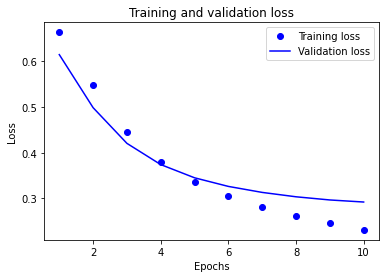

In [26]:
acc = history_dict['binary_accuracy']
val_acc = history_dict['val_binary_accuracy']
loss = history_dict['loss']
val_loss = history_dict['val_loss']

epochs = range(1, len(acc) + 1)

# "bo" is for "blue dot"
plt.plot(epochs, loss, 'bo', label='Training loss')
# b is for "solid blue line"
plt.plot(epochs, val_loss, 'b', label='Validation loss')
plt.title('Training and validation loss')
plt.xlabel('Epochs')
plt.ylabel('Loss')
plt.legend()

plt.show()

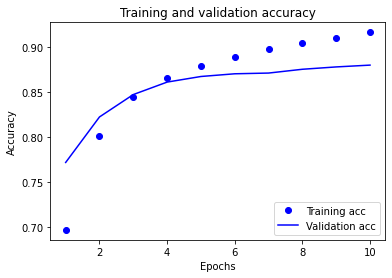

In [27]:
plt.plot(epochs, acc, 'bo', label='Training acc')
plt.plot(epochs, val_acc, 'b', label='Validation acc')
plt.title('Training and validation accuracy')
plt.xlabel('Epochs')
plt.ylabel('Accuracy')
plt.legend(loc='lower right')

plt.show()

**Training Data**
- Blue Dots
- Accuracy increases with each epoch
- Loss decreases with each epoch

<br>

**Validation Data**

- Blue Line
- Accuracy plateaus after 6 epochs
- Loss plateaus after 7-8 epochs

<br>

**Conclusion**

Since the validation loss and accuracy plateau before the training data, it means we are seeing overfitting from overtraining. 

Notice the training loss *decreases* with each epoch and the training accuracy *increases* with each epoch. This is expected when using a gradient descent optimization—it should minimize the desired quantity on every iteration.

<br>



---


Given the characteristics of our datasets discussed prior, we can prevent overfitting by calling the `tf.keras.callbacks.EarlyStopping` callback argument to stop the training before overfitting occurs. 

*This also helps with hypertuning as you can set a high value for your epoch and allow the model decide when to stop.*

## Export the model

Now that we haave finished with the model, we can export the model for deployment or future use. We used the `TextVectorization` layer on the data directly, but to make deployment easier, we can add thiss layer to the model.

<br>

We will create a new model that has the `TextVectorization` layer added in, but with the weights we have already trained.**bold text**

In [28]:
export_model = tf.keras.Sequential([
  vectorize_layer,
  model,
  layers.Activation('sigmoid')
])

export_model.compile(
    loss=losses.BinaryCrossentropy(from_logits=False), optimizer="adam", metrics=['accuracy']
)

# Test it with `raw_test_ds`, which yields raw strings
loss, accuracy = export_model.evaluate(raw_test_ds)
print(accuracy)

782/782 [==============================] - 7s 8ms/step - loss: 0.3104 - accuracy: 0.8734
0.8733999729156494


### Inference on new data

We can test out new reviews by calling the `model.predict()` function, and then inserting your text directly (as below), or you could pass through a list in an array. 

In [35]:
examples = [
  "The movie was really amazing, best movie ever!!!",
  "The movie was okay.",
  "The movie was terrible, literally the worst thing ever made",
  "TRY YOUR OWN CUSTOM ENTRY"
]

export_model.predict(examples)

1/1 [==============================] - 0s 28ms/step


array([[0.7073385 ],
       [0.4338148 ],
       [0.13832909],
       [0.499325  ]], dtype=float32)

We can now see the predictions of the model on the input text reviews. 

The higher the value (closer to 1) the more positive the review is, and the closer the prediction is to 0, the more negative the review is. 

With this information, you could have the model output the predictions, and then set up buckets or segments based on these values.

<br>

***This is a great example of how machine learning can aid in data analysis.***

# Next Steps

- Try using this approach on the [Twitter Sentiment Analysis](https://www.kaggle.com/datasets/jp797498e/twitter-entity-sentiment-analysis) dataset
- Create a report by segmenting the test data provided above.
- Try webscrapping for data collect